## What is unique here for FFPE samples 
Before creating a model, subsetting genes which is in the FFPE probe set

## Loading packages

In [1]:
import sys
import scanpy as sc
import anndata
import pandas as pd
pd.set_option('display.max_rows', 100)
import numpy as np
import matplotlib.pyplot as plt 
import matplotlib as mpl

import cell2location
import scvi

from matplotlib import rcParams
rcParams['pdf.fonttype'] = 42 # enables correct plotting of text
import seaborn as sns

import sctk

Global seed set to 0


In [2]:
results_folder = '/nfs/team205/heart/cell2location'

# create paths and names to results folders for reference regression and cell2location models
ref_run_name = f'{results_folder}/reference_signatures'
run_name = f'{results_folder}/cell2location_map'

## Data, parameters

In [32]:
scRNA_path='/nfs/team205/heart/anndata_objects/8regions/RNA_adult-8reg_raw_rmdblcls_cellstate-annotated.h5ad'

celltype_key='cell_state'

regions=['SAN-FFPE'] # ,'AVN','RV','LV','SP','AX','RA','LA',

## Loading scRNA-seq reference data

In [4]:
# Read scRNA data
adata_ref = sc.read(scRNA_path)

# Remove 'unclassified' cells
adata_ref = adata_ref[adata_ref.obs[celltype_key]!='unclassified']

# Make sure .var_names are ENSEMBL IDs
adata_ref.var

,gene_name_scRNA-0,gene_name_snRNA-1,gene_name_multiome-2
ENSG00000243485,MIR1302-2HG,MIR1302-2HG,MIR1302-2HG
ENSG00000237613,FAM138A,FAM138A,FAM138A
ENSG00000186092,OR4F5,OR4F5,OR4F5
ENSG00000238009,AL627309.1,AL627309.1,AL627309.1
ENSG00000239945,AL627309.3,AL627309.3,AL627309.3
...,...,...,...
ENSG00000277856,AC233755.2,AC233755.2,AC233755.2
ENSG00000275063,AC233755.1,AC233755.1,AC233755.1
ENSG00000271254,AC240274.1,AC240274.1,AC240274.1
ENSG00000277475,AC213203.1,AC213203.1,AC213203.2


In [5]:
adata_ref.obs['batch_key'].value_counts()

AH1_Nuclei_Multiome-v1    50220
D11_Cell_3prime-v3        44919
D2_Nuclei_3prime-v2       44855
H5_Nuclei_3prime-v3       37985
D6_Cell_3prime-v2         35958
A61_Nuclei_Multiome-v1    33692
D8_Nuclei_Multiome-v1     32926
H3_Nuclei_3prime-v3       32036
H7_Nuclei_3prime-v3       31453
H6_Nuclei_3prime-v3       27245
D4_Nuclei_3prime-v2       26676
H4_Nuclei_3prime-v3       25589
D5_Nuclei_3prime-v2       22516
D3_Nuclei_3prime-v2       22045
H2_Nuclei_3prime-v3       21199
D6_Cell_3prime-v3         20493
D6_Nuclei_3prime-v2       17878
D7_Cell_3prime-v2         17089
D7_Nuclei_3prime-v2       16801
D1_Nuclei_3prime-v2       15487
D11_Nuclei_3prime-v3      13777
D7_Nuclei_Multiome-v1     13423
D5_Cell_3prime-v2          6604
D3_Cell_3prime-v2          5325
D3_Nuclei_Multiome-v1      2508
D4_Cell_3prime-v2          1744
D1_Cell_3prime-v2           166
Name: batch_key, dtype: int64

In [6]:
set(adata_ref.obs[celltype_key])

{'AVN_P_cell',
 'AVN_bundle_cell',
 'Adip1',
 'Adip2',
 'Adip3',
 'Adip4',
 'B',
 'B_plasma',
 'CD14+Mo',
 'CD16+Mo',
 'CD4+T_Tfh',
 'CD4+T_Th1',
 'CD4+T_Th17',
 'CD4+T_Th2',
 'CD4+T_act',
 'CD4+T_naive',
 'CD4+T_reg',
 'CD8+T_cytox',
 'CD8+T_em',
 'CD8+T_te',
 'CD8+T_trans',
 'DC',
 'EC10_CMC-like',
 'EC1_cap',
 'EC2_cap',
 'EC3_cap',
 'EC4_immune',
 'EC5_art',
 'EC6_ven',
 'EC7_atria',
 'EC8_ln',
 'EC9_FB-like',
 'FB1',
 'FB2',
 'FB3',
 'FB4',
 'FB5',
 'FB6',
 'ILC',
 'LYVE1+IGF1+MP',
 'LYVE1+MP_cycling',
 'LYVE1+TIMD4+MP',
 'MAIT-like',
 'Mast',
 'Meso',
 'MoMP',
 'NC1',
 'NC2',
 'NC3',
 'NC4',
 'NC5',
 'NC6',
 'NK_CD16hi',
 'NK_CD56hi',
 'Neut',
 'PC1_vent',
 'PC2_atria',
 'PC3_str',
 'PC4_CMC-like',
 'SAN_P_cell',
 'SMC1_basic',
 'SMC2_art',
 'T/NK_cycling',
 'aCM1',
 'aCM2',
 'aCM3',
 'aCM4',
 'aCM5',
 'gdT',
 'vCM1',
 'vCM2',
 'vCM3',
 'vCM4',
 'vCM5'}

## Subset genes which is in FFPE-visium probe set

In [24]:
probe_genes = pd.read_csv('/nfs/team205/heart/cell2location/random/Visium_Human_Transcriptome_Probe_Set_v1.0_GRCh38-2020-A.csv',
                         skiprows=[0,1,2,3,4])
probe_genes = list(probe_genes[['DEPRECATED_' not in x for x in probe_genes['gene_id']]]['gene_id'])
print(len(probe_genes))
probe_genes[:5]

19902


['ENSG00000000003',
 'ENSG00000000005',
 'ENSG00000000419',
 'ENSG00000000457',
 'ENSG00000000460']

In [31]:
adata_ref = adata_ref[:,list(set(adata_ref.var_names).intersection(probe_genes))]
adata_ref

View of AnnData object with n_obs × n_vars = 620609 × 19095
    obs: 'sangerID', 'combinedID', 'donor', 'donor_type', 'region', 'region_finest', 'age', 'gender', 'facility', 'cell_or_nuclei', 'modality', 'kit_10x', 'flushed', 'n_genes', 'n_genes_by_counts', 'total_counts', 'total_counts_mt', 'pct_counts_mt', 'total_counts_ribo', 'pct_counts_ribo', 'scrublet_score', 'scrublet_leiden', 'cluster_scrublet_score', 'doublet_pval', 'doublet_bh_pval', 'batch_key', 'leiden_scVI', 'cell_type', 'cell_state_HCAv1', 'cell_state_scNym', 'cell_state_scNym_confidence', 'cell_state'
    var: 'gene_name_scRNA-0', 'gene_name_snRNA-1', 'gene_name_multiome-2'
    uns: 'cell_or_nuclei_colors', 'cell_state_HCAv1_colors', 'cell_state_colors', 'cell_state_scNym_colors', 'cell_type_colors', 'donor_colors', 'kit_10x_colors', 'leiden_scVI_colors', 'region_colors'
    obsm: 'X_scVI', 'X_umap', '_scvi_extra_continuous', 'latent_gene_encoding'
    obsp: 'connectivities', 'distances'

## Run per region: Estimation of reference cell type signatures (NB regression)

####### SAN-FFPE #######


Observation names are not unique. To make them unique, call `.obs_names_make_unique`.
Observation names are not unique. To make them unique, call `.obs_names_make_unique`.
Observation names are not unique. To make them unique, call `.obs_names_make_unique`.


                   pre  post_add-subsample
Adip1              558                 558
Adip2              203                 203
B                  126                 126
B_plasma             8                 275
CD14+Mo             87                2050
CD16+Mo            238                 238
CD4+T_act          296                 296
CD4+T_naive        358                 358
CD8+T_cytox         19                1341
CD8+T_em           167                 167
CD8+T_te            92                2023
CD8+T_trans        207                 207
DC                  57                 931
EC10_CMC-like      136                 136
EC1_cap            136                 136
EC2_cap             10                2003
EC3_cap             28                2006
EC4_immune          43                2018
EC5_art            374                 374
EC6_ven            389                 389
EC7_atria          899                 899
EC8_ln              42                1007
FB1        

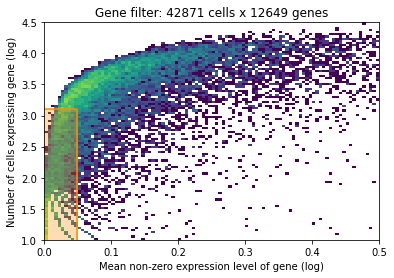

Observation names are not unique. To make them unique, call `.obs_names_make_unique`.
Observation names are not unique. To make them unique, call `.obs_names_make_unique`.
/lustre/scratch117/cellgen/team205/kk18/miniconda3/envs/cell2loc_env/lib/python3.9/site-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function setup_anndata is deprecated; Please use the model-specific setup_anndata methods instead. The global method will be removed in version 0.15.0.


INFO     Using batches from adata.obs["batch_key"]                                           
INFO     Using labels from adata.obs["cell_state"]                                           
INFO     Using data from adata.X                                                             
INFO     Successfully registered anndata object containing 42871 cells, 12649 vars, 27       
         batches, 49 labels, and 0 proteins. Also registered 0 extra categorical covariates  
         and 0 extra continuous covariates.                                                  
INFO     Please do not further modify adata until model is trained.                          


/lustre/scratch117/cellgen/team205/kk18/miniconda3/envs/cell2loc_env/lib/python3.9/site-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function view_anndata_setup is deprecated; This method will be removed in 0.15.0. Please avoid building any new dependencies on it.


Anndata setup with scvi-tools version 0.14.4.

              Data Summary              
┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━┓
┃             Data             ┃ Count ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━┩
│            Cells             │ 42871 │
│             Vars             │ 12649 │
│            Labels            │  49   │
│           Batches            │  27   │
│           Proteins           │   0   │
│ Extra Categorical Covariates │   0   │
│ Extra Continuous Covariates  │   0   │
└──────────────────────────────┴───────┘

             SCVI Data Registry              
┏━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━┓
┃     Data      ┃    scvi-tools Location    ┃
┡━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━┩
│       X       │          adata.X          │
│ batch_indices │ adata.obs['_scvi_batch']  │
│    labels     │ adata.obs['_scvi_labels'] │
└───────────────┴───────────────────────────┘

                          Label Categories                          
┏━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━┓
┃     Source Location     ┃    Categories    ┃ scvi-tools Encoding ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━┩
│ adata.obs['cell_state'] │      Adip1       │          0          │
│                         │      Adip2       │          1          │
│                         │        B         │          2          │
│                         │     B_plasma     │          3          │
│                         │     CD14+Mo      │          4          │
│                         │     CD16+Mo      │          5          │
│                         │    CD4+T_act     │          6          │
│                         │   CD4+T_naive    │          7          │
│                         │   CD8+T_cytox    │          8          │
│                         │     CD8+T_em     │          9          │
│                         │     CD8+T_te     │         10          │
│                         │   CD8+T_trans    │         11          │
│                         │        DC        │         12          │
│                         │  EC10_CMC-like   │         13          │
│                         │     EC1_cap      │         14          │
│                         │     EC2_cap      │         15          │
│                         │     EC3_cap      │         16          │
│                         │    EC4_immune    │         17          │
│                         │     EC5_art      │         18          │
│                         │     EC6_ven      │         19          │
│                         │    EC7_atria     │         20          │
│                         │      EC8_ln      │         21          │
│                         │       FB1        │         22          │
│                         │       FB2        │         23          │
│                         │       FB3        │         24          │
│                         │       FB4        │         25          │
│                         │       FB5        │         26          │
│                         │       FB6        │         27          │
│                         │       ILC        │         28          │
│                         │  LYVE1+IGF1+MP   │         29          │
│                         │ LYVE1+MP_cycling │         30          │
│                         │  LYVE1+TIMD4+MP  │         31          │
│                         │    MAIT-like     │         32          │
│                         │       Mast       │         33          │
│                         │       MoMP       │         34          │
│                         │       NC1        │         35          │
│                         │       NC2        │         36          │
│                         │    NK_CD16hi     │         37          │
│                         │    NK_CD56hi     │         38          │
│                         │       Neut       │         39          │
│                         │    PC2_atria     │         40          │
│                         │     PC3_str      │         41          │
│                         │    SAN_P_cell    │         42          │
│                         │    SMC1_basic    │         43          │
│                         │     SMC2_art     │         44          │
│                         │       aCM1       │         45          │
│                         │       aCM2       │         46          │
│                         │       aCM3       │         47          │
│                         │       aCM4       │         48          │
└─────────────────────────┴──────────────────┴─────────────────────┘

                            Batch Categories                             
┏━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━┓
┃    Source Location     ┃       Categories       ┃ scvi-tools Encoding ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━┩
│ adata.obs['batch_key'] │ A61_Nuclei_Multiome-v1 │          0          │
│                        │ AH1_Nuclei_Multiome-v1 │          1          │
│                        │   D11_Cell_3prime-v3   │          2          │
│                        │  D11_Nuclei_3prime-v3  │          3          │
│                        │   D1_Cell_3prime-v2    │          4          │
│                        │  D1_Nuclei_3prime-v2   │          5          │
│                        │  D2_Nuclei_3prime-v2   │          6          │
│                        │   D3_Cell_3prime-v2    │          7          │
│                        │  D3_Nuclei_3prime-v2   │          8          │
│                        │ D3_Nuclei_Multiome-v1  │          9          │
│                        │   D4_Cell_3prime-v2    │         10          │
│                        │  D4_Nuclei_3prime-v2   │         11          │
│                        │   D5_Cell_3prime-v2    │         12          │
│                        │  D5_Nuclei_3prime-v2   │         13          │
│                        │   D6_Cell_3prime-v2    │         14          │
│                        │   D6_Cell_3prime-v3    │         15          │
│                        │  D6_Nuclei_3prime-v2   │         16          │
│                        │   D7_Cell_3prime-v2    │         17          │
│                        │  D7_Nuclei_3prime-v2   │         18          │
│                        │ D7_Nuclei_Multiome-v1  │         19          │
│                        │ D8_Nuclei_Multiome-v1  │         20          │
│                        │  H2_Nuclei_3prime-v3   │         21          │
│                        │  H3_Nuclei_3prime-v3   │         22          │
│                        │  H4_Nuclei_3prime-v3   │         23          │
│                        │  H5_Nuclei_3prime-v3   │         24          │
│                        │  H6_Nuclei_3prime-v3   │         25          │
│                        │  H7_Nuclei_3prime-v3   │         26          │
└────────────────────────┴────────────────────────┴─────────────────────┘

GPU available: True, used: True
TPU available: False, using: 0 TPU cores
/lustre/scratch117/cellgen/team205/kk18/miniconda3/envs/cell2loc_env/lib/python3.9/site-packages/pytorch_lightning/trainer/configuration_validator.py:99: UserWarning: you passed in a val_dataloader but have no validation_step. Skipping val loop
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Sampling global variables, sample: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 999/999 [00:17<00:00, 56.78it/s]


/lustre/scratch117/cellgen/team205/kk18/miniconda3/envs/cell2loc_env/lib/python3.9/site-packages/anndata/_core/anndata.py:1228: FutureWarning: The `inplace` parameter in pandas.Categorical.reorder_categories is deprecated and will be removed in a future version. Reordering categories will always return a new Categorical object.
... storing 'sangerID' as categorical
/lustre/scratch117/cellgen/team205/kk18/miniconda3/envs/cell2loc_env/lib/python3.9/site-packages/anndata/_core/anndata.py:1228: FutureWarning: The `inplace` parameter in pandas.Categorical.reorder_categories is deprecated and will be removed in a future version. Reordering categories will always return a new Categorical object.
... storing 'combinedID' as categorical
/lustre/scratch117/cellgen/team205/kk18/miniconda3/envs/cell2loc_env/lib/python3.9/site-packages/anndata/_core/anndata.py:1228: FutureWarning: The `inplace` parameter in pandas.Categorical.reorder_categories is deprecated and will be removed in a future version.

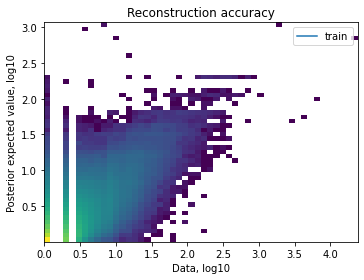

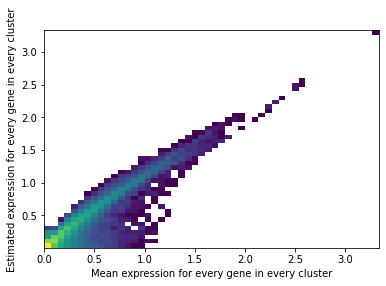

CPU times: user 1h 13min 21s, sys: 38min 16s, total: 1h 51min 38s
Wall time: 1h 21min 13s


In [34]:
%%time

from cell2location.utils.filtering import filter_genes
from cell2location.models import RegressionModel

for reg in regions:
    print(f'####### {reg} #######')
    
    # subset adata
    adata_sub = adata_ref[adata_ref.obs['region']==reg.replace('-FFPE','')].copy()
    
    # remove cell_states, which have less than 5 cells
    counts = adata_sub.obs[celltype_key].value_counts()
    adata_sub = adata_sub[adata_sub.obs[celltype_key].isin(list(counts.keys()[counts>=5]))]
    
    # add cells from other regions for low number (lower than 100) cell types
    counts = adata_sub.obs[celltype_key].value_counts()
    low_n_celltypes = list(counts.keys()[counts<100])
    ## add data of "other" regions & low_n_celltypes
    adata_toadd = adata_ref[(adata_ref.obs['region']!=reg)&(adata_ref.obs['cell_state'].isin(low_n_celltypes))]
    adata_sub = adata_sub.concatenate(adata_toadd,
                                     batch_key=None,
                                      index_unique=None)
    post_counts = adata_sub.obs[celltype_key].value_counts()
    
    # remove cell_states, which have only 2 cells or less
    # adata_sub = adata_sub[adata_sub.obs[celltype_key].isin(list(counts.keys()[post_counts>2]))]
    
    # downsize
    adata_sub = sctk.subsample(adata_sub, fraction=1, groupby=celltype_key, min_n=0, max_n=2000)
    
    # show pre add-sabsample and post
    post_counts = adata_sub.obs[celltype_key].value_counts()
    print(pd.DataFrame({'pre':counts,
                 'post_add-subsample':post_counts}))
    
    # before we estimate the reference cell type signature we recommend to perform very permissive genes selection
    # in this 2D histogram orange rectangle lays over excluded genes.
    # In this case, the downloaded dataset was already filtered using this method,
    # hence no density under the orange rectangle
    selected = filter_genes(adata_sub, cell_count_cutoff=5, cell_percentage_cutoff2=0.03, nonz_mean_cutoff=1.12)
    # filter the object
    adata_sub = adata_sub[:, selected].copy()
    
    # prepare anndata for the regression model
    adata_sub=adata_sub.copy()
    scvi.data.setup_anndata(adata=adata_sub, 
                            # 10X reaction / sample / batch
                            batch_key='batch_key', 
                            # cell type, covariate used for constructing signatures
                            labels_key=celltype_key, 
                            # multiplicative technical effects (platform, 3' vs 5', donor effect)
                            # categorical_covariate_keys=['Method']
                           )
    scvi.data.view_anndata_setup(adata_sub)
    
    # create and train the regression model
    mod = RegressionModel(adata_sub) 

    # Use all data for training (validation not implemented yet, train_size=1)
    mod.train(max_epochs=1000, batch_size=2500, train_size=1, lr=0.002, use_gpu=True)

    # plot ELBO loss history during training, removing first 20 epochs from the plot
    mod.plot_history(20)
    
    # In this section, we export the estimated cell abundance (summary of the posterior distribution).
    adata_sub = mod.export_posterior(
        adata_sub, sample_kwargs={'num_samples': 1000, 'batch_size': 2500, 'use_gpu': True}
    )

    # Save model
    mod.save(f"{ref_run_name}/{reg}", overwrite=True)

    # Save anndata object with results
    # adata_file = f"{ref_run_name}/{reg}/sc.h5ad"
    adata_sub.write(f"{ref_run_name}/{reg}/sc.h5ad")
    
    mod.plot_QC()
    
    # export estimated expression in each cluster
    if 'means_per_cluster_mu_fg' in adata_sub.varm.keys():
        inf_aver = adata_sub.varm['means_per_cluster_mu_fg'][[f'means_per_cluster_mu_fg_{i}' 
                                        for i in adata_sub.uns['mod']['factor_names']]].copy()
    else:
        inf_aver = adata_sub.var[[f'means_per_cluster_mu_fg_{i}' 
                                        for i in adata_sub.uns['mod']['factor_names']]].copy()
    inf_aver.columns = adata_sub.uns['mod']['factor_names']
    inf_aver.iloc[0:5, 0:5]
    
    # save inf_aver
    inf_aver.to_csv(f"{ref_run_name}/{reg}/inf_aver.csv")
                    
    del adata_sub, mod, inf_aver, adata_toadd, counts, post_counts